# preprocess of recurrence

In [1]:
import os
import random
import itertools
import re
import collections

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    ShuffleSplit,
    StratifiedShuffleSplit,
    KFold,
)

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

import networkx as nx


# config python file
import config

SEED = config.SEED
THRESHOLD_YEARS = config.THRESHOLD_YEARS
THRESHOLD_MONTHS = config.THRESHOLD_MONTHS
INDEX_MICROARRAY = config.INDEX_MICROARRAY
TARGET_NAME = "RFS_OVER_{0}MONTHS".format(THRESHOLD_MONTHS)

import functions

functions.fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")

## カラムの順序変更（読みやすさのため）

In [4]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    df_copy = df.copy()
    df_tmp = df_copy.filter(regex=regex)
    # 元のdfから落とす
    df_copy.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(df_copy, df_tmp, right_index=True, left_index=True)

In [5]:
# 癌の種類
df_clinical = align_columns(df_clinical, "^CANCER_")
# 重要そう（直感）な特徴量
df_clinical = align_columns(df_clinical, "^ER_|^HER2_|^TUMOR_")
# 治療の種類
df_clinical = align_columns(df_clinical, ".*THERAPY$|^BREAST_SURGERY")
# target系の種類（OS, RFS, VITAL）
df_clinical = align_columns(df_clinical, "^OS_.*|^RFS_.*|^VITAL_.*")

In [6]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]
df_MB.shape, df_MTST.shape

((1985, 36), (524, 36))

In [8]:
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR)
df_clinical.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_clinical.pkl"
)
df_MB.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_MTST.pkl")

## 臨床データの読み込み

In [9]:
df_clinical = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_clinical.pkl"
)
df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_MB.pkl")
df_MTST = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_MTST.pkl"
)

## 遺伝子データの読み込み

In [10]:
# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()

# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()


dict_gene_expressions = dict(
    {
        "mrna_agilent_microarray": df_mrna_agilent_microarray,
        "mrna_agilent_microarray_zscores_ref_all_samples": df_mrna_agilent_microarray_zscores_ref_all_samples,
        "mrna_agilent_microarray_zscores_ref_diploid_samples": df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    }
)
dict_genes = {
    "cna": df_cna,
    "methylation_promoters_rrbs": df_methylation_promoters_rrbs,
    "mrna_agilent_microarray_zscores_ref_all_samples": df_mrna_agilent_microarray_zscores_ref_all_samples,
    "mrna_agilent_microarray_zscores_ref_diploid_samples": df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    "mrna_agilent_microarray": df_mrna_agilent_microarray,
}

# 目的変数の生成

モデルに入力する段階の仮定として、再発は既に判明している（データ取得時にはすでに手術を終えている状況であり、再発の有無についても見ているため）。
そこで、【再発年数が**n年**以内か、以後か】に注目し、RFS_MONTHSから目的変数を生成する。    
RFS_MONTHSは非再発者の最終フォローアップまでの月数も記録されているが、そちらはデータフレームを操作するときにRFS_STATUSからフィルタリングする。

In [14]:
functions.check(df_MB)

,feature,dtypes,nan,count,max,min,num_unique,unique,unique_counts
0,LYMPH_NODES_EXAMINED_POSITIVE,float64,76,1908,45.000000,0.000000,31,,
1,NPI,float64,1,1983,6.680000,1.000000,323,,
2,CELLULARITY,object,68,1916,nan,nan,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 214}"
3,COHORT,float64,0,1984,5.000000,1.000000,5,[1. 2. 3. 5. 4.],"{3.0: 762, 1.0: 526, 2.0: 288, 4.0: 238, 5.0: 170}"
4,INFERRED_MENOPAUSAL_STATE,object,5,1979,nan,nan,2,['Post' 'Pre' nan],"{'Post': 1555, 'Pre': 424}"
5,SEX,object,0,1984,nan,nan,1,['Female'],{'Female': 1984}
6,INTCLUST,object,5,1979,nan,nan,11,['4ER+' '3' '9' '7' '4ER-' nan '5' '8' '10' '1' '2' '6'],"{'8': 299, '3': 290, '4ER+': 260, '10': 226, '5': 190, '7': 189, '9': 146, '1': 139, '6': 85, '4ER-': 83, '2': 72}"
7,AGE_AT_DIAGNOSIS,float64,0,1984,96.290000,21.930000,1623,,
8,CLAUDIN_SUBTYPE,object,5,1979,nan,nan,7,['claudin-low' 'LumA' 'LumB' 'Normal' nan 'Her2' 'Basal' 'NC'],"{'LumA': 699, 'LumB': 475, 'Her2': 224, 'claudin-low': 218, 'Basal': 209, 'Normal': 148, 'NC': 6}"
9,THREEGENE,object,221,1763,nan,nan,4,['ER-/HER2-' 'ER+/HER2- High Prolif' nan 'ER+/HER2- Low Prolif' 'HER2+'],"{'ER+/HER2- Low Prolif': 640, 'ER+/HER2- High Prolif': 616, 'ER-/HER2-': 309, 'HER2+': 198}"


In [16]:
# RFS_STATUSのみにnullがあるため、そのデータについては患者データを削除する
df_MB.dropna(subset="RFS_STATUS", inplace=True)
# IDをindexにしたほうが都合がよいので変更
# df_MB.set_index("PATIENT_ID", inplace=True)
# 予測ラベルを扱いやすい形に変更
df_MB["RFS_STATUS"] = df_MB["RFS_STATUS"].replace(
    {"1:Recurred": 1, "0:Not Recurred": 0}
)

In [17]:
def make_target(target_months: int = THRESHOLD_MONTHS):
    df_MB[TARGET_NAME] = pd.cut(
        df_MB["RFS_MONTHS"], [0, target_months, np.inf], labels=[False, True]
    )


make_target()
# 欠損値の削除
df_MB.dropna(inplace=True, subset=TARGET_NAME)

# 特徴エンジニアリング

## 臨床データ
予測の**層別化に必要な特徴を作成**する。

**層別化に必要な特徴**
- CLAUDIN_SUBTYPE
- NPI
- TUMOR_SIZE
- LYMPH_NODES_EXAMINED_POSITIVE

数値データは層別化のためにカテゴリ化を行う。
各カテゴリ化の根拠は以下の通り。
- NPI：( ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index )
- TUMOR_SIZE：乳癌のステージの定義( https://oshiete-gan.jp/breast/diagnosis/stages/detail.html )
- LYMPH_NODES_EXAMINED_POSITIVE：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

In [18]:
df_MB["NPI_CAT"] = pd.cut(
    df_MB.NPI,
    [0, 2.0, 2.4, 3.4, 5.4, np.inf],
    labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
)
df_MB["TUMOR_CAT"] = pd.cut(
    df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
)
df_MB["LYMPH_CAT"] = pd.cut(
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
    [-np.inf, 0, 3, np.inf],
    labels=["0", "1~3", "4~inf"],
)

## 遺伝子データ

**重複カラムのrename**

有識者の意見：『重複した遺伝子発現は別の遺伝子発現として扱うべき』とのことなので、重複する遺伝子特徴名はrenameする

参考：https://www.web-dev-qa-db-ja.com/ja/python/pandasdataframe%E5%90%8C%E3%81%98%E5%90%8D%E5%89%8D%E3%81%AE%E8%A4%87%E6%95%B0%E3%81%AE%E5%88%97%E3%81%AE%E5%90%8D%E5%89%8D%E3%82%92%E5%A4%89%E6%9B%B4/1046763736/

**欠損値の削除**

- 欠損値が多量 → 特徴を削除する。  
- 欠損値が少量 → 考え中...（削除 or 極端な値での補完）

### 特徴名のrename

In [19]:
df_gene_expressions = dict_gene_expressions["mrna_agilent_microarray"].copy()
# 重複特徴量の確認
print(
    "重複特徴名数（rename前）：",
    df_gene_expressions.columns[df_gene_expressions.columns.duplicated()]
    .value_counts()
    .sum(),
)

cols = pd.Series(df_gene_expressions.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [
        dup + "_" + str(i) if i != 0 else dup for i in range(sum(cols == dup))
    ]

# rename the columns with the cols list.
df_gene_expressions.columns = cols
# 重複特徴量の確認
print(
    "重複特徴名数（rename後）：",
    df_gene_expressions.columns[df_gene_expressions.columns.duplicated()]
    .value_counts()
    .sum(),
)

重複特徴名数（rename前）： 194
重複特徴名数（rename後）： 0


### 欠損値の削除

欠損値が多い特徴個数： 0
欠損値が少ない特徴個数： 8


<AxesSubplot:xlabel='Hugo_Symbol'>

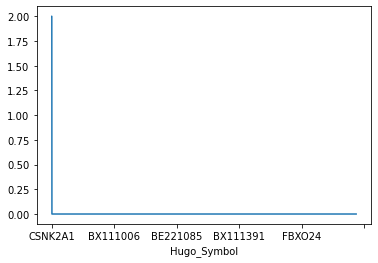

In [20]:
print(
    "欠損値が多い特徴個数：",
    (df_gene_expressions.isnull().sum() > df_gene_expressions.shape[0] // 10).sum(),
)
print(
    "欠損値が少ない特徴個数：",
    (
        (df_gene_expressions.isnull().sum() < +df_gene_expressions.shape[0] // 10)
        & (df_gene_expressions.isnull().sum() > 0)
    ).sum(),
)
series_gene_expressions_name = df_gene_expressions.isnull().sum().sort_values()[::-1]
series_gene_expressions_name.plot()

In [21]:
# 多数の欠損値を持つ特徴
many_null_gene_expressions_names = series_gene_expressions_name[
    df_gene_expressions.isnull().sum() > df_gene_expressions.shape[0] // 10
].index
# 少数の欠損値を持つ特徴
few_null_gene_expressions_names = series_gene_expressions_name[
    (df_gene_expressions.isnull().sum() <= df_gene_expressions.shape[0] // 10)
    & (df_gene_expressions.isnull().sum() > 0)
]
# 少数の欠損値の遺伝子発現を持つ患者ID
list_patient_id_contains_null_expressions = list()
for name in few_null_gene_expressions_names.index:
    for patient_id in df_gene_expressions[df_gene_expressions[name].isnull()].index:
        list_patient_id_contains_null_expressions.append(patient_id)

# 多数の欠損値を持つ特徴の削除
df_gene_expressions.drop(many_null_gene_expressions_names, axis=1, inplace=True)
# 少数の欠損値の遺伝子発現を持つ患者の削除
df_gene_expressions.drop(list_patient_id_contains_null_expressions, inplace=True)

In [22]:
df_gene_expressions.shape

(1894, 24368)

# 臨床データと遺伝子データの結合

患者の必要な特徴を含む臨床データと遺伝子データを結合する。

## 臨床データ

### 必要な特徴

**目的変数**
- RFS_OVER_nMONTHS  

**層別化対象候補**
- CLAUDIN_SUBTYPE
- NPI_CAT
- TUMOR_CAT
- LYMPH_CAT

## 遺伝子データ
遺伝子データは全てのデータを結合する。

In [24]:
left_columns = [
    "RFS_STATUS",
    TARGET_NAME,
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]

df_merged = pd.merge(
    df_MB[left_columns],
    df_gene_expressions,
    left_index=True,
    right_index=True,
)

functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR)
df_merged.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_merged.pkl")

# 再発者の抽出

再発者のみを対象とするため、再発者を抽出する

In [26]:
df_recurrenced = df_merged[df_merged["RFS_STATUS"] == 1].drop("RFS_STATUS", axis=1)
df_recurrenced.shape

# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR)
df_recurrenced.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)

## データ分割

訓練データ、検証データ、テストデータに層化分割する   
比率は(train, val, test)=(0.81, 0.09, 0.1)  
CVは行わずに通常のholdoutで検証は行う（特徴選択を毎度実施するのが厄介なため）


In [27]:
# データ分割のためのクラス
# pythonのミュータブルオブジェクトの外部操作を防ぐためにcopy()の使用&private化
class SplitDataFrame:
    def __init__(self, df):
        self.__df = df.copy()
        self.__train_size = 0.9

        self.__df_train_val = None
        self.__df_train = None
        self.__df_val = None
        self.__df_test = None

        self.__X_train_val = None
        self.__y_train_val = None
        self.__X_train = None
        self.__y_train = None
        self.__X_val = None
        self.__y_val = None
        self.__X_test = None
        self.__y_test = None

    def split_train_val_test(self):
        self.__df_train_val, self.__df_test = train_test_split(
            self.__df,
            train_size=self.__train_size,
            stratify=self.__df[TARGET_NAME],
            random_state=SEED,
        )

        self.__df_train, self.__df_val = train_test_split(
            self.__df_train_val,
            train_size=self.__train_size,
            stratify=self.__df_train_val[TARGET_NAME],
            random_state=SEED,
        )

    def split_X_y(self):
        self.__X_train, self.__y_train = (
            self.__df_train.drop(TARGET_NAME, axis=1),
            self.__df_train[TARGET_NAME],
        )
        self.__X_val, self.__y_val = (
            self.__df_val.drop(TARGET_NAME, axis=1),
            self.__df_val[TARGET_NAME],
        )
        self.__X_train_val, self.__y_train_val = (
            self.__df_train_val.drop(TARGET_NAME, axis=1),
            self.__df_train_val[TARGET_NAME],
        )
        self.__X_test, self.__y_test = (
            self.__df_test.drop(TARGET_NAME, axis=1),
            self.__df_test[TARGET_NAME],
        )

    def get_train_val_Xy(self):
        return self.__X_train_val.copy(), self.__y_train_val.copy()

    def get_train_Xy(self):
        return self.__X_train.copy(), self.__y_train.copy()

    def get_val_Xy(self):
        return self.__X_val.copy(), self.__y_val.copy()

    def get_test_Xy(self):
        return self.__X_test.copy(), self.__y_test.copy()

# 特徴選択

特徴数が多いため、特徴数を削減する

**目安**
サンプル数が767件であり、8割程度が学習に使用できる(train : val : test = 0.9*0.9 : 0.9*0.1 : 0.1)ため、学習データの1割程度の60個を選択後上限数の目安とする

In [28]:
# 適用する処理毎にdfをまとめたclass


class PreprocessDataFrame:
    def __init__(self, df_raw):
        self.__raw = df_raw.copy()
        self.__preprocessed = None
        self.__preprocess_methods = list()

    def get_preprocessed_df(self):
        return self.__preprocessed.copy()

    def get_preprocess_methods(self):
        return self.__preprocess_methods.copy()

    def set_variance_threshold(self, df):
        """
        分散によるフィルターで特徴を選択したdf
        """
        self.__preprocess_methods.append("variance_threshold")
        self.__preprocessed = df

    def set_mrmr(self, df):
        """
        mrmrで特徴を選択したdf
        """
        self.__preprocess_methods.append("mrmr")
        self.__preprocessed = df

## 手法毎に前処理を行う関数の実装


In [31]:
def save_preprocessed_df(
    list_train: list(),
    list_val: list(),
    list_train_val: list(),
    list_test: list(),
    file_path: str = ".",
    file_name: str = "sample",
):
    """
    params
    list_train: [X_train, y_train]
    list_val: [X_val, y_val]
    list_train_val: [X_train_val, y_train_val]
    list_test: [X_val, y_val]
    """
    functions.make_dir("{0}/train".format(file_path))
    list_train[0].to_pickle("{0}/train/X_{1}.pkl".format(file_path, file_name))
    list_train[1].to_pickle("{0}/train/y_{1}.pkl".format(file_path, file_name))
    functions.make_dir("{0}/val".format(file_path))
    list_val[0].to_pickle("{0}/val/X_{1}.pkl".format(file_path, file_name))
    list_val[1].to_pickle("{0}/val/y_{1}.pkl".format(file_path, file_name))

    functions.make_dir("{0}/train_val".format(file_path))
    list_train_val[0].to_pickle("{0}/train_val/X_{1}.pkl".format(file_path, file_name))
    list_train_val[1].to_pickle("{0}/train_val/y_{1}.pkl".format(file_path, file_name))
    functions.make_dir("{0}/test".format(file_path))
    list_test[0].to_pickle("{0}/test/X_{1}.pkl".format(file_path, file_name))
    list_test[1].to_pickle("{0}/test/y_{1}.pkl".format(file_path, file_name))

In [33]:
def select_features(
    df: pd.DataFrame(),
    method: str = "variance_threshold",
    file_path: str = ".",
    file_name: str = "sample",
):
    _df = df.copy()

    # データが少なすぎる場合は特徴選択しない
    if _df.shape[0] > 99:
        # データ分割

        sp = SplitDataFrame(_df)
        sp.split_train_val_test()
        sp.split_X_y()

        X_train_val, y_train_val = sp.get_train_val_Xy()
        X_train, y_train = sp.get_train_Xy()
        X_val, y_val = sp.get_val_Xy()
        X_test, y_test = sp.get_test_Xy()

        # 初期化
        pd_train = PreprocessDataFrame(X_train)
        pd_val = PreprocessDataFrame(X_val)
        pd_train_val = PreprocessDataFrame(X_train_val)
        pd_test = PreprocessDataFrame(X_test)

        if method == "variance_threshold":
            # 分散値上位の特徴を抽出
            features = (
                X_train.var().sort_values().tail(X_train.shape[0] // 10).index
            )  # 学習データの1/10サイズ
            pd_train.set_variance_threshold(X_train[features])
            pd_val.set_variance_threshold(X_val[features])

            features = (
                X_train_val.var()
                .sort_values()
                .tail(X_train_val.shape[0] // 10)
                .index  # 学習データの1/10サイズ
            )
            pd_train_val.set_variance_threshold(X_train_val[features])
            pd_test.set_variance_threshold(X_test[features])
        elif method == "mrmr":
            features = mrmr.mrmr_classif(
                X=X_train,
                y=y_train,
                K=X_train.shape[0] // 10,  # 学習データの1/10サイズ
                show_progress=False,
            )
            pd_train.set_variance_threshold(X_train[features])
            pd_val.set_variance_threshold(X_val[features])

            features = mrmr.mrmr_classif(
                X=X_train_val,
                y=y_train_val,
                K=X_train_val.shape[0] // 10,  # 学習データの1/10サイズ
                show_progress=False,
            )
            pd_train_val.set_variance_threshold(X_train_val[features])
            pd_test.set_variance_threshold(X_test[features])
        else:
            print("no defined method")
            exit

        # 保存
        save_preprocessed_df(
            list_train=[pd_train.get_preprocessed_df(), y_train],
            list_val=[pd_val.get_preprocessed_df(), y_val],
            list_train_val=[pd_train_val.get_preprocessed_df(), y_train_val],
            list_test=[pd_test.get_preprocessed_df(), y_test],
            file_path=file_path,
            file_name=file_name,
        )


# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]

methods = ["variance_threshold", "mrmr"]

for method in tqdm(methods):  # 特徴選択手法の適用
    df = df_recurrenced.drop(subgroup_columns, axis=1)
    file_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
        "ALL_DATA",
        method,
    )
    select_features(
        df, method=method, file_path=file_path, file_name="all_data"
    )  # データ全体への特徴選択
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                subgroup_columns, axis=1
            )
            file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                method,
            )
            functions.make_dir(file_path)
            select_features(
                df, method=method, file_path=file_path, file_name=subgroup
            )  # サブグループ毎への特徴選択

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [26:30<00:00, 795.31s/it]


## 最適な特徴量数の実験（全データ）

特徴量選択数を変化させ、学習曲線を描画する
※実装途中

In [ ]:
# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]


def observe_features_num(method: str = "variance_threshold"):

    for subgroup_column in tqdm(subgroup_columns):
        for subgroup in df_recurrenced[subgroup_column].unique():
            df_genes = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                subgroup_columns, axis=1
            )
            # データが少なすぎる場合は特徴選択しない
            if df_genes.shape[0] > 99:
                # データ分割

                sp = SplitDataFrame(df_genes)
                sp.split_train_val_test()
                sp.split_X_y()

                X_train_val, y_train_val = sp.get_train_val_Xy()
                X_train, y_train = sp.get_train_Xy()
                X_val, y_val = sp.get_val_Xy()
                X_test, y_test = sp.get_test_Xy()

                # 初期化
                pd_train = PreprocessDataFrame(X_train)
                pd_val = PreprocessDataFrame(X_val)
                pd_train_val = PreprocessDataFrame(X_train_val)
                pd_test = PreprocessDataFrame(X_test)

                if method == "variance_threshold":
                    # 分散値上位の特徴を抽出
                    features = (
                        X_train.var().sort_values().tail(X_train.shape[0] // 10).index
                    )
                    pd_train.set_variance_threshold(X_train[features])
                    pd_val.set_variance_threshold(X_val[features])

                    features = (
                        X_train_val.var()
                        .sort_values()
                        .tail(X_train_val.shape[0] // 10)
                        .index
                    )
                    pd_train_val.set_variance_threshold(X_train_val[features])
                    pd_test.set_variance_threshold(X_test[features])
                elif method == "mrmr":
                    features = mrmr.mrmr_classif(
                        X=X_train,
                        y=y_train,
                        K=X_train.shape[0] // 10,
                        show_progress=False,
                    )
                    pd_train.set_variance_threshold(X_train[features])
                    pd_val.set_variance_threshold(X_val[features])

                    features = mrmr.mrmr_classif(
                        X=X_train_val,
                        y=y_train_val,
                        K=X_train_val.shape[0] // 10,
                        show_progress=False,
                    )
                    pd_train_val.set_variance_threshold(X_train_val[features])
                    pd_test.set_variance_threshold(X_test[features])
                else:
                    print("no defined method")
                    exit

In [ ]:
def calc_features_num(
    mircroarray_type: str,
    cat_name: str,
    method: str,
    clf: callable,
    max_k: int = 100,
    min_k: int = 10,
    span: int = 10,
):
    for year in tqdm(range(15, 16, 5)):  # 予後年数毎のループ

        prognosis_Xlabel = "X{0}".format(year)
        prognosis_ylabel = "y{0}".format(year)
        # 特徴量選択から行うので特徴量選択前のデータから使用
        X_concat = pd.concat(
            [
                X_dict[mircroarray_type][cat_name]["raw"]["train"][prognosis_Xlabel],
                X_dict[mircroarray_type][cat_name]["raw"]["val"][prognosis_Xlabel],
            ]
        )
        y_concat = pd.concat(
            [
                y_dict[mircroarray_type][cat_name]["raw"]["train"][prognosis_ylabel],
                y_dict[mircroarray_type][cat_name]["raw"]["val"][prognosis_ylabel],
            ]
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_concat, y_concat, stratify=y_train, train_size=0.5, random_state=SEED
        )

        fig, axes = plt.subplots(
            2,
            (max_k - min_k) // span + 1,
            figsize=(6 * ((max_k - min_k) // span + 1), 6),
        )
        cv = StratifiedShuffleSplit(n_splits=5, random_state=SEED)

        for k in range(min_k, max_k + 1, span):
            features = mrmr.mrmr_classif(
                X=X_train,
                y=y_train,
                K=k,
                show_progress=False,
            )
            title = "features size: {0}".format(len(features))

            # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
            plot_learning_curve(
                clf,
                title,
                X_val[features],
                y_val,
                axes=axes[:, (k - min_k) // span],
                ylim=(0.49, 1.01),
                cv=cv,
                n_jobs=4,
                scoring="f1_score",
            )
        make_dir(
            config.FIGURES_PREPROCESS_PROGNOSIS_CROSS_DIR
            + "/learning_curve/{0}/{1}".format(mircroarray_type, method)
        )
        plt.savefig(
            config.FIGURES_PREPROCESS_PROGNOSIS_CROSS_DIR
            + "/learning_curve/{0}/{1}/{2}.png".format(
                mircroarray_type, method, prognosis_Xlabel
            )
        )